In [1]:
import numpy as np
import matplotlib.pyplot as plt

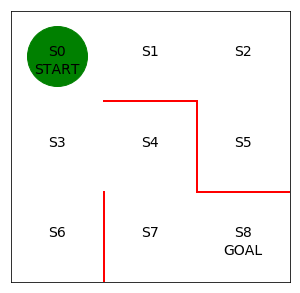

In [2]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

#draw walls
plt.plot([1,1], [0,1], color='r', linewidth=2)
plt.plot([1,2], [2,2], color='r', linewidth=2)
plt.plot([2,2], [2,1], color='r', linewidth=2)
plt.plot([2,3], [1,1], color='r', linewidth=2)

#write status
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', size=14, ha='center')
plt.text(2.5, 0.3, 'GOAL', size=14, ha='center')

ax.set_xlim(0,3)
ax.set_ylim(0,3)

plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, right=False, left=False, labelleft=False)

line, = ax.plot([0.5], [2.5], marker='o', color='g', markersize=60)

In [3]:
def softmax_comvert_theta_into_pi(theta):
    beta = 1
    m, n = theta.shape
    pi = np.zeros((m, n))
    exp_theta = np.exp(beta * theta)
    
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        
    pi = np.nan_to_num(pi)
    
    return pi

In [4]:
theta0 = np.array([[np.nan, 1, 1, np.nan],  #s0
                   [np.nan, 1, np.nan, 1], #s1
                   [np.nan, np.nan, 1, 1], #s2
                   [1, 1, 1, np.nan],
                   [np.nan, np.nan, 1, 1],
                   [1, np.nan, np.nan, np.nan],
                   [1, np.nan, np.nan, np.nan],
                   [1, 1, np.nan, np.nan], #s7
                   ])
pi0 = softmax_comvert_theta_into_pi(theta0)

In [5]:
def get_action_and_next_s(pi, s):
    direction = ['up', 'right', 'down', 'left']
    
    next_direction = np.random.choice(direction, p=pi[s, :])
    
    if next_direction == 'up':
        return [0, s - 3]
    elif next_direction == 'right':
        return [1, s + 1]
    elif next_direction == 'down':
        return [2, s + 3]
    else:
        return [3, s - 1]
    
def goal_maze(pi):
    s = 0
    s_a_history = [[0, np.nan]]
    
    while True:
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        
        s_a_history.append([next_s, np.nan])
        
        if next_s is 8:
            break
        else:
            s = next_s
    return s_a_history

def update_theta(theta, pi, s_a_history):
    eta = 0.1 #learning-rate
    T = len(s_a_history)
    
    m, n = theta.shape
    delta_theta = theta.copy()
    
    for i in range(0, m):
        for j in range(0, n):
            if not np.isnan(theta[i, j]):
                sa_i = [sa for sa in s_a_history if sa[0] == i]
                sa_ij = [sa for sa in s_a_history if sa == [i, j]]
                
                N_i = len(sa_i)
                N_ij = len(sa_ij)
                delta_theta[i, j] = (N_ij + pi[i,j] * N_i) / T
    
    return theta + eta * delta_theta

In [7]:
stop_epsilon = 1e-8
theta = theta0
pi = pi0

is_continue = True
count = 1

while is_continue:
    s_a_history = goal_maze(pi)
    new_theta = update_theta(theta, pi, s_a_history)
    new_pi = softmax_comvert_theta_into_pi(new_theta)
    
    print(np.sum(np.abs(new_pi - pi)))
    print('step:', len(s_a_history)-1)
    
    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

0.027762224638339827
step: 6
0.007375533476807139
step: 112
0.011050207034929427
step: 32
0.01440778305217233
step: 30
0.012425032294212157
step: 48
0.007065456940173798
step: 38
0.015274769089611118
step: 34
0.014083516356445946
step: 42
0.007654611025596114
step: 100
0.0058048156517249705
step: 74
0.017142933523610904
step: 22
0.00723437774768132
step: 20
0.007086350480640546
step: 170
0.012081607330635236
step: 24
0.03935556528634382
step: 4
0.014200703469529119
step: 20
0.021659489476547666
step: 24
0.012747852020016048
step: 20
0.012138630687171248
step: 42
0.014855243069621327
step: 36
0.015488360557629477
step: 20
0.028962387509537613
step: 6
0.00601966037387569
step: 88
0.020418472912933194
step: 36
0.017370671233931878
step: 24
0.007037135237197234
step: 126
0.02316156461078961
step: 10
0.006018627159513401
step: 56
0.005722334893212
step: 192
0.007548891450579298
step: 132
0.010850642370859642
step: 34
0.011340316585647159
step: 48
0.01619477482906634
step: 14
0.0119069135484

5.152405491719386e-05
step: 4
4.95055134016545e-05
step: 4
4.756598593702468e-05
step: 4
4.570238463590922e-05
step: 4
4.391174189628076e-05
step: 4
4.2191205750800196e-05
step: 4
4.0538035381713615e-05
step: 4
3.894959682308953e-05
step: 4
3.7423358808133566e-05
step: 4
3.595688879878955e-05
step: 4
3.454784914325947e-05
step: 4
3.319399340031612e-05
step: 4
3.189316279644847e-05
step: 4
3.0643282818723916e-05
step: 4
2.944235994102428e-05
step: 4
2.828847847618051e-05
step: 4
2.7179797549845012e-05
step: 4
2.6114548188032197e-05
step: 4
2.509103052232244e-05
step: 4
2.4107611096949598e-05
step: 4
2.3162720285810623e-05
step: 4
2.2254849803990114e-05
step: 4
2.138255032121812e-05
step: 4
2.0544429161321777e-05
step: 4
1.973914809656828e-05
step: 4
1.896542122464189e-05
step: 4
1.822201292551518e-05
step: 4
1.7507735905844502e-05
step: 4
1.6821449307617025e-05
step: 4
1.616205690056785e-05
step: 4
1.5528505338867178e-05
step: 4
1.491978248826996e-05
step: 4
1.4334915814328068e-05
step:

In [11]:
np.set_printoptions(precision=3, suppress=True)
pi

array([[0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.384, 0.   , 0.616],
       [0.   , 0.   , 0.473, 0.527],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   ]])

In [10]:
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([], [])
    return line,

def animate(i):
    state = s_a_history[i][0]
    x = state % 3 + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())